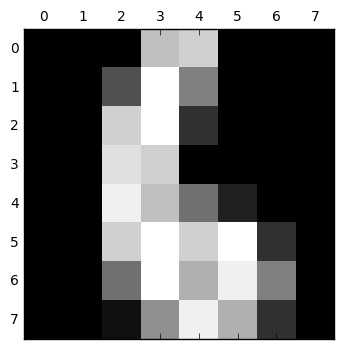

In [20]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt 
import sklearn

from sklearn.datasets import load_digits

digits = load_digits(n_class=10)
X = digits.images
y = digits.target

plt.gray()
plt.matshow(X[6]) 
plt.show()

import numpy as np
X = np.expand_dims(digits.images, axis=1)

In [2]:
print("number of samples: %d" % len(X))

number of samples: 1797


In [3]:
#Define our training, test and validation sets
X_train = X[:1000]
y_train = y[:1000]
X_val = X[1000:1400]
y_val = y[1000:1400]
X_test = X[1400:]
y_test = y[1400:]

In [4]:
import theano
import theano.tensor as T
import lasagne

input_var = T.tensor4('inputs')
target_var = T.ivector('targets')

# Let's start building our network!
# Starting with the input layer...
network = {}
network['data'] = lasagne.layers.InputLayer(shape=(None, 1, 8, 8), input_var=input_var)


/Users/shaziaakbar/anaconda/lib/python3.5/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


## Lasagne Layer

Lasagne has several types of layers that you can tailor to your needs. In my case where I am analysing 2D images here are some of the basic layers I can use:

<ul>
<li>InputLayer</li>
<li>Conv2DLayer</li>
<li>MaxPool2DLayer</li>
<li>DenseLayer</li>
<li>DropoutLayer</li>
</ul>

For a full list: http://lasagne.readthedocs.io/en/latest/modules/layers.html

They generally take the form <strong>lasagne.layers.[Type] (network, [Parameters])"</strong>
...

## LeNet5
We'll use the LeNet architecture as inspiration (not exactly because we don't have a lot of data to work with)
<img src="lenet5.png">

In [5]:
# Layer 1 (Conv)
network['conv1'] = lasagne.layers.Conv2DLayer(network['data'], num_filters=32, 
    W=lasagne.init.GlorotUniform(), filter_size=3)

# Layer 2 (Max-pool)
network['pool1'] = lasagne.layers.MaxPool2DLayer(network['conv1'], pool_size=2)

# Layer 3 (Conv)
network['conv2'] = lasagne.layers.Conv2DLayer(network['pool1'], num_filters=32, filter_size=2)

# Layer 4 (Max-pool)
network['pool2'] = lasagne.layers.MaxPool2DLayer(network['conv2'], pool_size=2)

# Layer 5 (Fully conn)
network['fc1'] = lasagne.layers.DenseLayer(network['pool2'], num_units=64, 
	nonlinearity=lasagne.nonlinearities.rectify) 

# Layer 6 (Fully conn)
network['out'] = lasagne.layers.DenseLayer(network['fc1'], num_units=10, 
    nonlinearity=lasagne.nonlinearities.softmax)

## Set up functions 

Once the model is defined, next you need to specify the functions that you're going to use during training/testing.

Remember from our last journal club we need to specify:
<ul>
<li>Cost function: this is used during backpropagation when we need to determine the optimal weights given the output (i.e. prediction)
<li>Update function: this defines what method we will use to iteratively update the weights in each epoch </li>
</ul>

In [6]:
#define the loss function (mean cross entropy)
prediction = lasagne.layers.get_output(network['out'])
loss = lasagne.objectives.categorical_crossentropy(prediction, target_var)
loss = loss.mean()

/Users/shaziaakbar/anaconda/lib/python3.5/site-packages/lasagne/layers/conv.py:489: UserWarning: The `image_shape` keyword argument to `tensor.nnet.conv2d` is deprecated, it has been renamed to `input_shape`.
  border_mode=border_mode)


In [7]:
lr = 0.01 # the learning rate needs to be large enough to learn 
          # fast enough but slow enough to make sure the minimum isn't missed.

params = lasagne.layers.get_all_params(network['out'], trainable=True)
updates = lasagne.updates.sgd(
        loss, params, learning_rate=lr)

Next stage is all theano setup functions and then we can start training!

In [8]:
#define the training function
train_fn = theano.function([input_var, target_var], loss, updates=updates, allow_input_downcast=True)

#these are all parameters and statistics that we would like to keep track off during testing/validation
test_prediction = lasagne.layers.get_output(network['out'], deterministic=True)
test_loss = lasagne.objectives.categorical_crossentropy(test_prediction, target_var)
test_loss = test_loss.mean()
test_acc = T.mean(T.eq(T.argmax(test_prediction, axis=1), target_var), dtype=theano.config.floatX)

#define the test/validation function
val_fn = theano.function([input_var, target_var], [test_loss, test_acc], allow_input_downcast=True)

/Users/shaziaakbar/anaconda/lib/python3.5/site-packages/lasagne/layers/conv.py:489: UserWarning: The `image_shape` keyword argument to `tensor.nnet.conv2d` is deprecated, it has been renamed to `input_shape`.
  border_mode=border_mode)


In [9]:
import numpy as np
def mini_batch(inputs, targets, batch_size=500, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs)- batch_size + 1, batch_size):
        if shuffle:
            excerpt = indices[start_idx : start_idx + batch_size]
        else:
            excerpt = slice(start_idx, start_idx + batch_size)
        yield inputs[excerpt], targets[excerpt]
        

num_epochs = 50
batch_size = 100

print("Starting training...")
for epoch in range(num_epochs):
    train_err=0
    train_batches=0

    #Full pass over the training data 
    for batch in mini_batch(X_train, y_train, batch_size=batch_size, shuffle=True):
        inputs, targets = batch
        train_err += train_fn(inputs, targets)
        train_batches += 1

Starting training...


So there are a few terms here that we should explain...

First the number of epochs are the number of times you want to update the weights in the network. Typically this ranges from 50 - 500 depending on how much data samples and processing power you have.
The batch size is just how many images each subset will contain.

Next we run through each epoch and:
- run "mini_batch" which is a small function which splits our dataset into smaller subsets
- call our theano training function defined above: train_fn
- increment a counter to keep track of how many epochs we've done
    

In [10]:
    #next we look at performance in our validation set INSIDE the epoch for loop
    val_err=0
    val_acc=0
    val_batches=0

    #Full pass over the validation data 
    for batch in mini_batch(X_val, y_val, batch_size=batch_size, shuffle=True):
        inputs, targets = batch
        err, acc = val_fn(inputs, targets)
        val_err += err
        val_acc += acc
        val_batches += 1

    # Print the results
    print("  training loss:\t\t{:.6f}".format(train_err / train_batches))
    print("  validation loss:\t\t{:.6f}".format(val_err / val_batches))
    print("  validation accuracy:\t\t{:.2f} %".format(
        val_acc / val_batches * 100))

  training loss:		0.071614
  validation loss:		0.140305
  validation accuracy:		95.25 %


You can see it's very similar to the training procedure but this time we use the validation set and the val_fn function. Other than that everything else is the same.

Now we test our trained model on our test set...

In [11]:
# After training, we compute and print the test error:
test_err = 0
test_acc = 0
test_batches = 0
for batch in mini_batch(X_test, y_test, batch_size=batch_size, shuffle=False):
    inputs, targets = batch
    err, acc = val_fn(inputs, targets)
    test_err += err
    test_acc += acc
    test_batches += 1
print("Final results:")
print("  test loss:\t\t\t{:.6f}".format(test_err / test_batches))
print("  test accuracy:\t\t{:.2f} %".format(
    test_acc / test_batches * 100))	

Final results:
  test loss:			0.453910
  test accuracy:		87.67 %


### Voila! 
You're very own CNN network! Wasn't too hard after all and lasagne does most of the work for you in terms of intergrating cost, activation and update functions. The rest is just python and some theano syntax.

In [12]:
#saving the model

import pickle
with open('mnist.pkl', 'wb') as output:
      pickle.dump(network, output, pickle.HIGHEST_PROTOCOL)

<module 'matplotlib.pyplot' from '/Users/shaziaakbar/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py'>

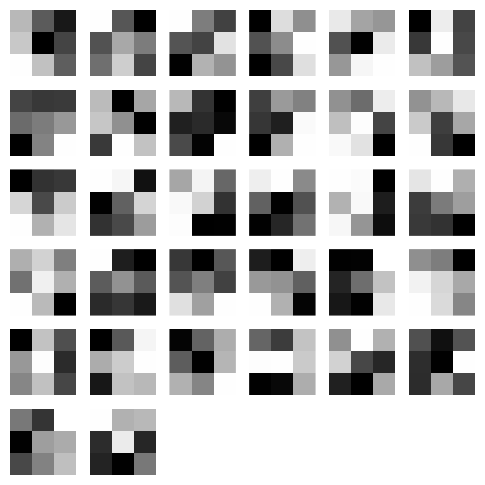

In [13]:
#try out some visualizations...

import nolearn_vis

nolearn_vis.plot_conv_weights(network['conv1'])

/Users/shaziaakbar/anaconda/lib/python3.5/site-packages/lasagne/layers/conv.py:489: UserWarning: The `image_shape` keyword argument to `tensor.nnet.conv2d` is deprecated, it has been renamed to `input_shape`.
  border_mode=border_mode)


<module 'matplotlib.pyplot' from '/Users/shaziaakbar/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py'>

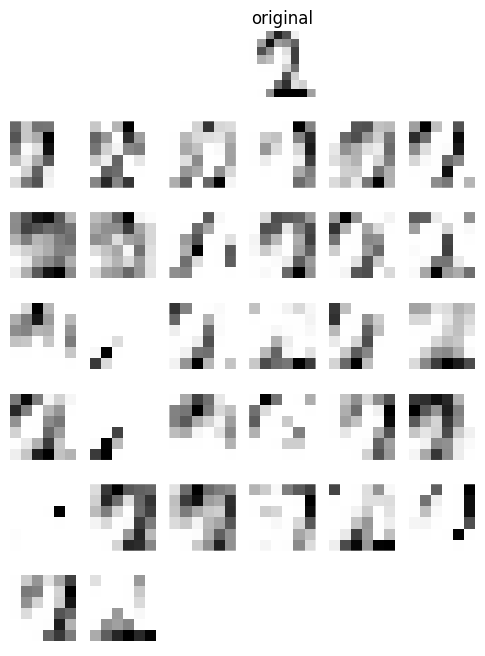

In [14]:
nolearn_vis.plot_conv_activity(network['conv1'], np.expand_dims(X_test[0], axis=0))